## SSH along the coast

Runs with horizontaly varying statification.

The idea is to try to follow the surface signals generated by the wind blowing over Sebastián Vizcaino Bay as they travel north along a series of synthetic stations that we can the compare to gauge measurements. We will measure the amplification of the signals at the Southern California Bight with respect to the amplitudes exhibited at the northern Baja California coast. We will split the signals into barotropic and baroclinic components.

In [2]:
from netCDF4 import Dataset
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import MITgcmutils as mit
import numpy as np
from scipy import signal
import seaborn as sns
import sys
sys.path.append('/Users/Karina/Research/SVB/notebooks_SVB/')
import svb_tools as svb
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
from scipy.signal import butter, filtfilt

def butter_highpass(higcut, fs, order=5):
    nyq = 0.5 * fs
    high = higcut / nyq
    b, a = butter(order, high, btype='high')
    return b, a


def butter_highpass_filter(data, highcut, fs, order=5, axis=-1):
    b, a = butter_highpass(highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=axis)
    return y

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='low')
    return b, a


def butter_lowpass_filter(data, lowcut, fs, order=5, axis=-1):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = filtfilt(b, a, data, axis=axis)
    return y
def plot_amplification(outdir,lat_inds,lon_inds,ax1,ax2,title='',filt=None, tini=0, tend=-1, cutoff=4.0):
    
    eta = mit.mnc.mnc_files(outdir+'eta.0000000000.t*.nc', layout='exch2')
    
    fs = 1/600
    cutfreq = 1/(cutoff*3600)
 
    if filt == 'highpass':
        eta_st4 = np.squeeze(eta.variables['ETAN'][:,:,lat_inds[3],lon_inds[3]]-
                             eta.variables['ETAN'][0,:,lat_inds[3],lon_inds[3]])*100
        eta_filt4 = butter_highpass_filter(eta_st4, cutfreq, fs, order=5)
    elif filt == 'lowpass':
        eta_st4 = np.squeeze(eta.variables['ETAN'][:,:,lat_inds[3],lon_inds[3]]-
                             eta.variables['ETAN'][0,:,lat_inds[3],lon_inds[3]])*100
        eta_filt4 = butter_lowpass_filter(eta_st4, cutfreq, fs, order=5)
    else:
        eta_filt4 = np.squeeze(eta.variables['ETAN'][:,:,lat_inds[3],lon_inds[3]]-
                               eta.variables['ETAN'][0,:,lat_inds[3],lon_inds[3]])*100
 
    max_ind4 = np.argmax(eta_filt4[tini:tend])
    max_ssh4 = np.max(eta_filt4[tini:tend])

    for ii, col in zip(range(3,len(lat_inds)),colors[3:]):
        
        if filt == 'highpass':
            eta_ts = np.squeeze(eta.variables['ETAN'][:,:,lat_inds[ii],lon_inds[ii]]-
                                eta.variables['ETAN'][0,:,lat_inds[ii],lon_inds[ii]])*100
            eta_filt = butter_highpass_filter(eta_ts, cutfreq, fs, order=5)
        elif filt =='lowpass':
            eta_ts = np.squeeze(eta.variables['ETAN'][:,:,lat_inds[ii],lon_inds[ii]]-
                                eta.variables['ETAN'][0,:,lat_inds[ii],lon_inds[ii]])*100
            eta_filt = butter_lowpass_filter(eta_ts, cutfreq, fs, order=5)
        else:
            eta_filt = np.squeeze(eta.variables['ETAN'][:,:,lat_inds[ii],lon_inds[ii]]-
                                  eta.variables['ETAN'][0,:,lat_inds[ii],lon_inds[ii]])*100
        
        ax1.plot(time/3600,(eta_filt),'-', label=r'%1.1f$^{\circ}$ N' %LAT[lat_inds[ii],0], color=col)
        max_ind = np.argmax(eta_filt[tini:tend])
        ax1.plot(time[max_ind+tini]/3600, np.max(eta_filt[tini:tend]), 'ko',markeredgecolor='0.5')
        ax2.plot(LAT[lat_inds[ii],0],np.max(eta_filt[tini:tend])/max_ssh4,'o',
                 color=col,markersize=10, markeredgecolor='0.5',
                 label=r'%1.1f$^{\circ}$ N' %LAT[lat_inds[ii],0])
    eta.close()
    ax1.axvline(time[tini]/3600, color='k',linestyle='--')
    ax1.axvline(time[tend]/3600, color='k',linestyle='--')
    ax1.axvline(3.6, color='0.5', linestyle=':')
    ax1.set_ylabel('Free surface / cm')
    ax1.set_xlabel('Hours')
    ax1.set_xlim(0,24)
    ax2.legend(bbox_to_anchor=(1,1.05),handletextpad=0, labelspacing=0 )
    ax2.set_ylabel('Amplification')
    ax2.set_xlabel('Station latitude')
    ax1.set_title(title)
    return(ax1,ax2)

### February reference T and S (horizontally homogeneous density)

In [4]:
outdir = '/Volumes/KYUUBI/SVB/05_448x512x100/03_feb/mnc_test_0001/'

In [5]:
bat = mit.mnc.mnc_files(outdir+'grid.t*.nc', layout='exch2')
depth = bat.variables['Depth'][:]
lat = bat.variables['Y'][:]
lon = bat.variables['X'][:]
LAT = bat.variables['YC'][:]
LON = bat.variables['XC'][:]-360
Z = bat.variables['Z'][:]
Zl = bat.variables['Zl'][:]

# Cell-centers mask
hFacC = bat.variables['HFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
bat.close()

# Dynamics
dyn = mit.mnc.mnc_files(outdir+'dynVars.0000000000.t*.nc', layout='exch2')
Zind = (dyn.variables['diag_levels'][:]).astype(int)
time = dyn.variables['T'][:]
dyn.close()

### Domain and virtual stations

* Virtual stations try to be as close to the coast as possible (black contour).
* Dark grey contour: 250 m (shelf break)
* Light gray: 500 m

In [6]:
# NOAA stations
lon_noaa = [-(117+15.4/60), -(118+16.4/60), -(118+30.0/60), -(119+41.6/60), -(120+45.3/60)]
lat_noaa = [32+52.0/60, 33+43.2/60, 34+0.5/60,34+24.2/60, 35+10.1/60]
st_noaa  = ['La Jolla', 'Los Angeles', 'Santa Monica', 'Santa Barbara' , 'Port San Luis']

# REDMAR stations
lon_red = [-(116+37.067/60), -(115+58/60+38.95/3600) ]
lat_red = [31+50.894/60, 30+29/60+4.23/3600]
st_red  = ['Ensenada', 'San Quintin']

Depth at station 1: 6.0 m 
Depth at station 2: 4.0 m 
Depth at station 3: 2.0 m 
Depth at station 4: 8.0 m 
Depth at station 5: 2.0 m 
Depth at station 6: 6.0 m 
Depth at station 7: 4.0 m 
Depth at station 8: 6.0 m 
Depth at station 9: 2.0 m 
Depth at station 10: 2.0 m 
Depth at station 11: 2.0 m 
Depth at station 12: 4.0 m 
Depth at station 13: 2.0 m 
Depth at station 14: 4.0 m 


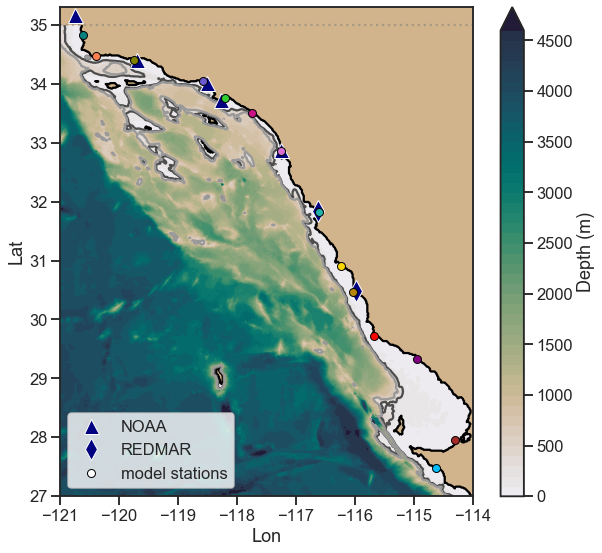

In [7]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')
pc = ax.contourf(LON,LAT,np.ma.masked_array(depth, mask=mask_dep),50,
                 vmin=0, vmax=5000, cmap=cmo.cm.rain, extend='max')
cb = plt.colorbar(pc, extend='max',label='depth / m')
cn = ax.contour(LON,LAT,depth, colors=['0','0.3','0.6'], levels=[0,250,500])
ax.axhline(35, linestyle=':', color='0.5', alpha=0.5)
ax.plot(lon_noaa, lat_noaa, '^',color='navy',markeredgecolor='w', markersize=15)
ax.plot(lon_red, lat_red, 'd',color='navy', markeredgecolor='w', markersize=15)

lon_inds = [408,428,387,340,317,304,280,239,208,155,178,80,38,24]
lat_inds = [30,61,149,174,221,250,308,374,415,450,432,473,477,500]
st_model = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14']
colors = ['deepskyblue','brown','purple','red','darkgoldenrod','gold','lightseagreen',
          'orchid','mediumvioletred', 'slateblue','limegreen','olive','coral','teal']

# ssh transects
for ii, st, col in zip(range(len(lon_inds)),st_model, colors):
    ax.plot(LON[0,lon_inds[ii]],LAT[lat_inds[ii],0],'o', markersize=8, color=col, markeredgecolor='k')
    print('Depth at station %s: %1.1f m ' % (st,depth[lat_inds[ii],lon_inds[ii]]))


cb.set_label('Depth (m)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(239-360, 246-360)
ax.set_ylim(27,35.3)
ax.set_aspect(1)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],linestyle='', markerfacecolor='navy', 
                          marker='^', label='NOAA', markersize=15, markeredgecolor='w'),
                Line2D([0], [0], linestyle='',markerfacecolor='navy', marker='d', label='REDMAR', markersize=15, markeredgecolor='w'),
                Line2D([0], [0], linestyle='',markerfacecolor='w', marker='o', label='model stations', markersize=8, markeredgecolor='k'), 
               ]
ax.legend(handles=legend_elements)


### Time series


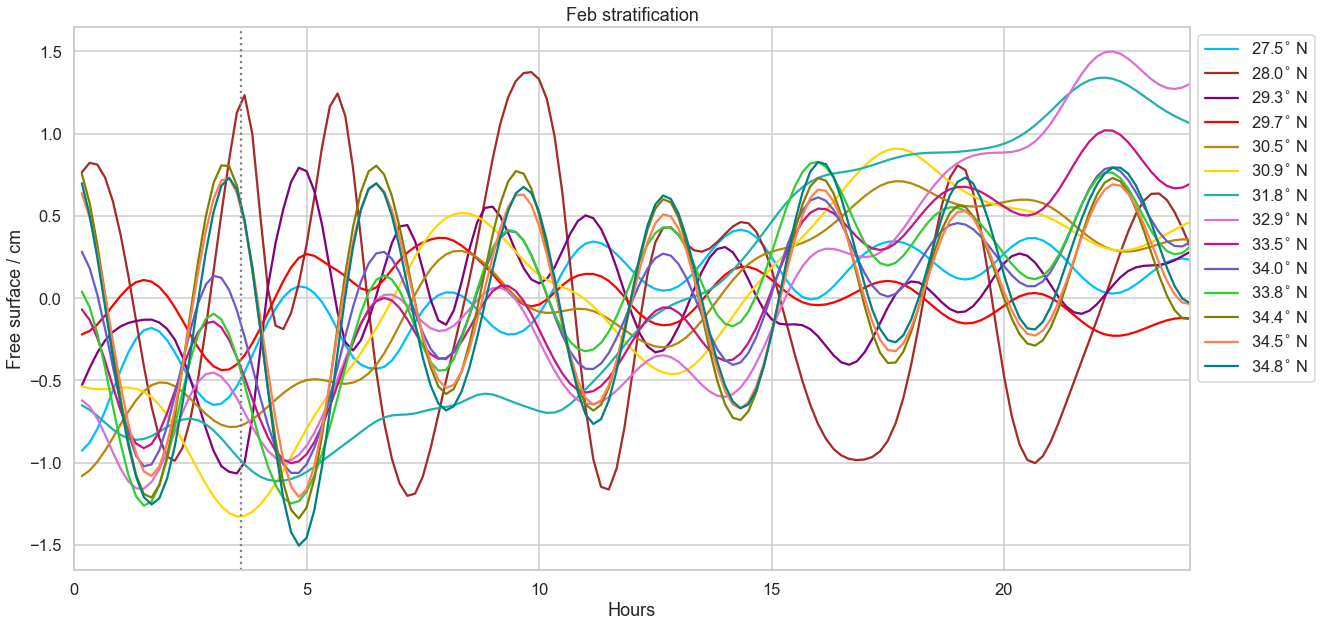

In [13]:
sns.set_context('talk')
sns.set_style('whitegrid')
fig1, (ax1) = plt.subplots(1,1, figsize=(20,10), sharey=True,sharex=True)
eta = mit.mnc.mnc_files(outdir+'eta.0000000000.t*.nc', layout='exch2')
for ii,col in zip(range(len(lat_inds)),colors):
    eta_ts = np.squeeze(eta.variables['ETAN'][:,:,lat_inds[ii],lon_inds[ii]])
    ax1.plot(time/3600,(eta_ts-np.mean(eta_ts))*1E2,'-', label=r'%1.1f$^{\circ}$ N' %LAT[lat_inds[ii],0], color=col)
eta.close()
ax1.axvline(3.6, color='0.5', linestyle=':')

ax1.set_ylabel('Free surface / cm')
ax1.set_xlabel('Hours')
ax1.set_xlim(0,24)
ax1.legend(bbox_to_anchor=(1,1))
ax1.set_title('Feb stratification')
plt.show()
  

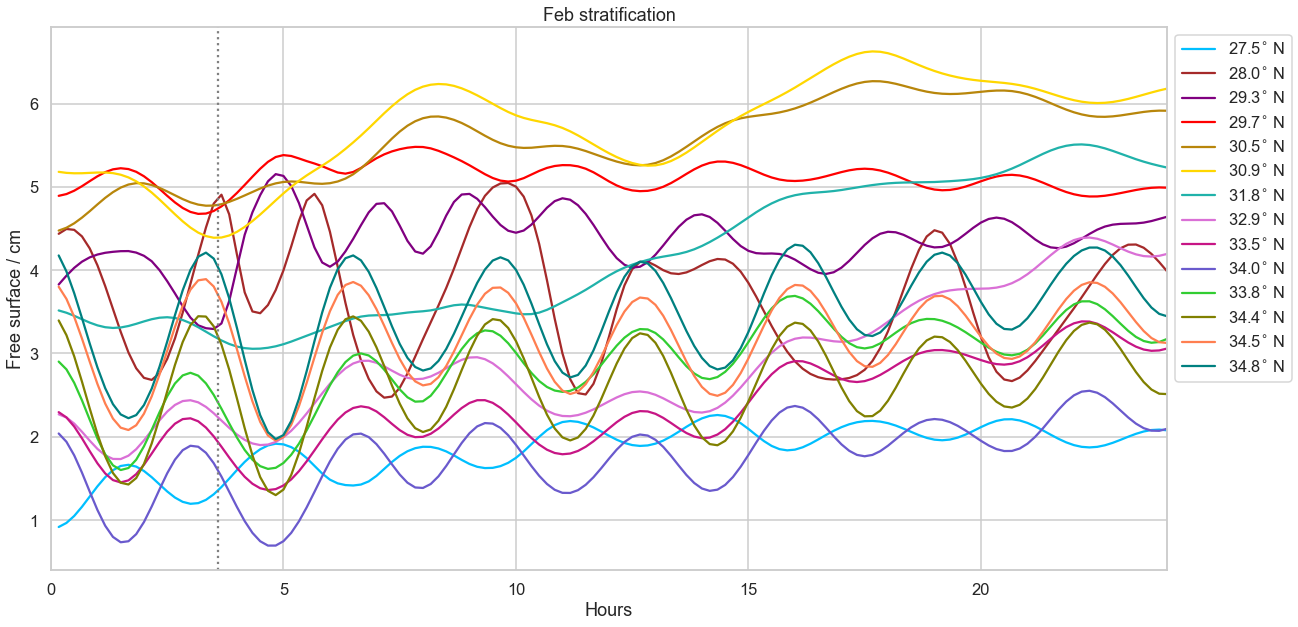

In [14]:
sns.set_context('talk')
sns.set_style('whitegrid')
fig1, (ax1) = plt.subplots(1,1, figsize=(20,10), sharey=True,sharex=True)
eta = mit.mnc.mnc_files(outdir+'eta.0000000000.t*.nc', layout='exch2')
for ii, col in zip(range(len(lat_inds)),colors):
    eta_ts = np.squeeze(eta.variables['ETAN'][:,:,lat_inds[ii],lon_inds[ii]])
    ax1.plot(time/3600,(eta_ts)*1E2+(0.5*ii),'-', label=r'%1.1f$^{\circ}$ N' %LAT[lat_inds[ii],0], color=col)
eta.close()
ax1.axvline(3.6, color='0.5', linestyle=':')
ax1.set_ylabel('Free surface / cm')
ax1.set_xlabel('Hours')
ax1.set_xlim(0,24)
ax1.legend(bbox_to_anchor=(1,1))
ax1.set_title('Feb stratification')
plt.show()
  

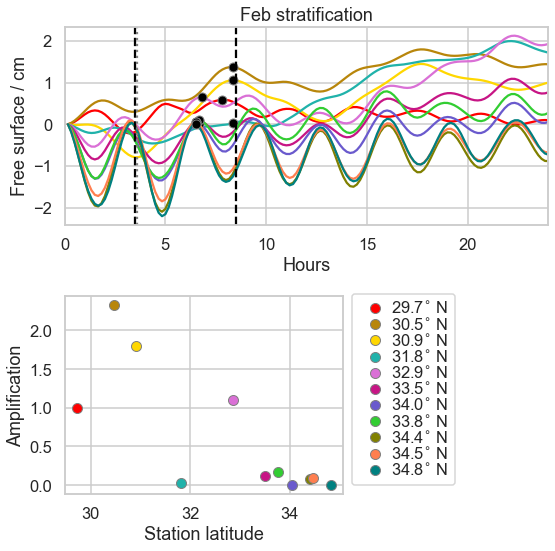

In [15]:
period = 1
title = 'Feb stratification'
tini = 20
tend = 50

fig = plt.figure(tight_layout=True, figsize=(8,8))
gs = GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1,0:2])

ax1,ax2 = plot_amplification(outdir,lat_inds,lon_inds,ax1,ax2,title=title,filt=None, 
                             tini=tini, tend=tend, cutoff=period)

### Filter 4.8 h period signal 

Cut-off at 4 hr

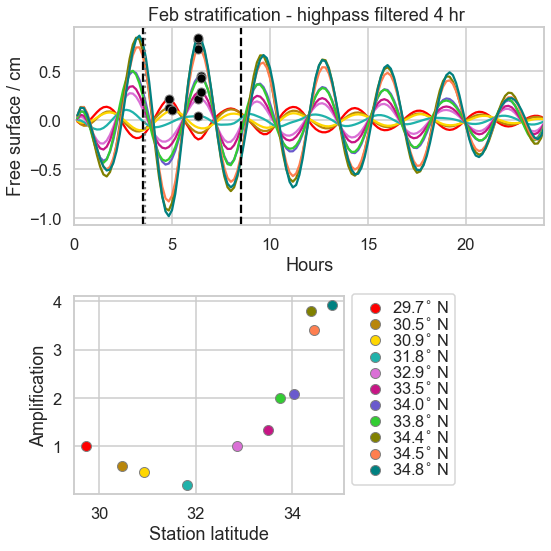

In [16]:
period = 4.0
title = 'Feb stratification - highpass filtered %g hr ' %period
tini = 20
tend = 50

fig = plt.figure(tight_layout=True, figsize=(8,8))
gs = GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1,0:2])

ax1,ax2 = plot_amplification(outdir,lat_inds,lon_inds,ax1,ax2,title=title,filt='highpass', 
                             tini=tini, tend=tend, cutoff=period)

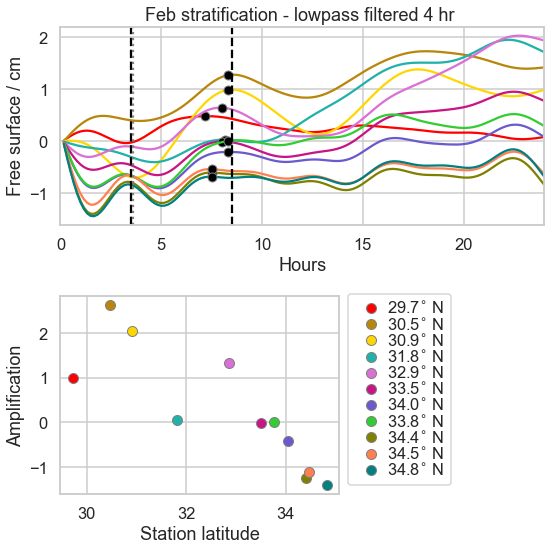

In [17]:
period = 4.0
title = 'Feb stratification - lowpass filtered %g hr ' %period
tini = 20
tend = 50

fig = plt.figure(tight_layout=True, figsize=(8,8))
gs = GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1,0:2])

ax1,ax2 = plot_amplification(outdir,lat_inds,lon_inds,ax1,ax2,title=title,filt='lowpass', 
                             tini=tini, tend=tend, cutoff=period)